In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from argparse import ArgumentParser
from decimal import *
import math
import numpy.matlib
import types
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
import os
from sklearn.model_selection import KFold
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

In [2]:

def parameter_file(data_name):
        FOLD_NO = 5
        a = 0.0
        c = 1.0
        b = 0.34 # Found by hyperparametertuning 
        q = 0.499
        length = 20000
        num_classes = 2  
        eps = np.arange(0.001,0.3,0.006)
        epsilon = np.append(eps,0.3)
        return a, b, c, q, length, num_classes, epsilon, FOLD_NO

In [3]:
def skew_tent(x,a,b,c):
# b is the parameters of the map.a and c are 0 and 1 respectively.
# GLS maps are piece wise linear
# Based on the value of check- the function will return any of the two diffrent maps.  If Check = "Sk-T", 
# then skew-tent map is returned else skew-binary map is returned.
        if x < b:
            xn = ((c - a)*(x-a))/(b - a)
        else:
            xn = ((-(c-a)*(x-b))/(c - b)) + (c - a)
        return xn

In [4]:
def iterations(q, a, b, c, length):
    #The function return a time series and its index values 
    timeseries = (np.zeros((length,2)))
    timeseries[0,0] = q
    for i in range(1, length):
        timeseries[i,0] = skew_tent((timeseries[i-1,0]), a, b, c)
        timeseries[i,1] = np.int(i)
    return timeseries

In [5]:

def firingtime_calculation(X_train, timeseries, epsilon):
# Code for calculating firing time
    M = X_train.shape[0]
    N = X_train.shape[1]
    firingtime = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N):
            A = (np.abs((X_train[i,j]) - timeseries[:,0]) < epsilon)
            firingtime[i,j] = timeseries[A.tolist().index(True),1]
    return firingtime

In [6]:
def probability_calculation(X_train, timeseries, b, epsilon):
    # Code for calculating tt-ss method based feature extraction
    M = X_train.shape[0]
    N = X_train.shape[1]
    probability = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N):
            A = (np.abs(X_train[i,j] - timeseries[:,0]) < epsilon)
            #firingtime[i,j] = timeseries[A.tolist().index(True),1]
            freq = (timeseries[0:np.int(timeseries[A.tolist().index(True),1]),0] - b < 0)
            if len(freq) == 0:
                probability[i, j] = 0
            else: 
                probability[i,j] = freq.tolist().count(False)/np.float(len(freq))
    return probability 

In [7]:
# code for Caluculating the mean representation vectors
def class_avg_distance(DistMat, y_train, lab):
    samples = y_train.shape[0]
    P = y_train.tolist().count([lab])
    Q = DistMat.shape[1]
    class_dist = np.zeros((P,Q))
    k =0
    for i in range(0, samples):
        if (y_train[i] == lab):
            class_dist[k,:]=DistMat[i,:]
            k = k+1
    return np.sum(class_dist, axis = 0)/class_dist.shape[0]

In [8]:

def cosine_similar_measure(test_firingtime, y_test, a, b, c, avg_class_dist):    
    i = 0
    y_pred_val = []
    sim = []
    tot_sim = []
    for a_val in test_firingtime:
        sim = []
        for b_val in avg_class_dist:
            sim.append(cosine_similarity(a_val.reshape(1,len(a_val)),b_val.reshape(1, len(b_val))))
        tot_sim.append(sim)
        y_pred_val.append(np.argmax(tot_sim[i]))
        i = i+1
    accuracy = accuracy_score(y_test, y_pred_val)*100
    recall = recall_score(y_test, y_pred_val , average="macro")
    precision = precision_score(y_test, y_pred_val , average="macro")
    f1 = f1_score(y_test, y_pred_val, average="macro")
    cma = cm(y_test,y_pred_val)  

    print("Confusion matrix\n", cma)
    return y_pred_val

In [9]:
def class_wise_data(X_train, y_train, lab):
## This code takes all data from a given class and stores in the matrix data
    N = len(y_train)
    l = y_train.tolist().count(lab)
    label = lab * np.ones((l,1))
    data = np.zeros((l,X_train.shape[1]))
    p = 0
    for i in range(0, N):
        if (y_train[i] == lab):
            data[p, :] = X_train[i, :]
            p = p+1
    return data, label


In [10]:
def test_split_generator(X_train, y_train, num_classes, samples_per_class):
# This function generates the test size required for train test split 
    data_array =[] 
    test_split = []
    for i in range(0, num_classes):
        X, y = class_wise_data(X_train, y_train, lab = i)
        sample_split = []
        for j in range(1, samples_per_class + 1):
            sample_split.append(1 - np.float(j)/X.shape[0])
        test_split.append(sample_split)
    return test_split


In [11]:
def CHAOSNET(X_train, y_train, X_test, y_test, num_classes, q, a, b, c, length, epsilon):
        num_features = X_train.shape[1]
        timeseries = iterations(q, a, b, c, length )
        test_proba = probability_calculation(X_test, timeseries, b, epsilon)


        train_proba = probability_calculation(X_train, timeseries, b, epsilon)
        avg_class_dist_1 = np.zeros((num_classes,num_features))

        for n_cl in range(0, num_classes):
            avg_temp = class_avg_distance(train_proba, y_train, lab = n_cl)
            avg_class_dist_1[n_cl,:] = avg_temp
    
        #avg_class_dist_1 = []
        #for n_cl in range(0,num_classes):
        #avg_class_dist_1.append(class_avg_distance(train_proba, y_train_subsample, lab = n_cl))
        print( " avg_class_dist_1 = ", avg_class_dist_1)
        y_pred_val = cosine_similar_measure(test_proba, y_test, a, b, c, avg_class_dist_1)
        accuracy = accuracy_score(y_test, y_pred_val)*100
        f1 = f1_score(y_test, y_pred_val, average="macro")
        print("acc and f1 are", accuracy, f1 )
        return y_pred_val, avg_class_dist_1




In [12]:
def k_cross_validation(FOLD_NO, traindata, trainlabel, testdata, testlabel, num_classes, q, b, epsilon):
    KF = KFold(n_splits= FOLD_NO, shuffle=True) # Define the split - into 2 folds 
    KF.get_n_splits(traindata) # returns the number of splitting iterations in the cross-validator
    print(KF) 
    FSCORE = np.zeros((1, len(epsilon)))
    ACC = np.zeros((1,  len(epsilon)))
    EPS = np.zeros((1,  len(epsilon)))

    WIDTH = -1


    for EPSILON_1 in epsilon:
                WIDTH = WIDTH + 1
                FSCORE_TEMP=[]
                ACCUR = []
            
                for TRAIN_INDEX, VAL_INDEX in KF.split(traindata):
                    
                    X_TRAIN, X_VAL = traindata[TRAIN_INDEX], traindata[VAL_INDEX]
                    Y_TRAIN, Y_VAL = trainlabel[TRAIN_INDEX], trainlabel[VAL_INDEX]
                    
                    
                    Y_PRED, mean_each_class = CHAOSNET(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, num_classes, q, a, b, c, length, EPSILON_1)

                    F1SCORE = f1_score(Y_VAL, Y_PRED, average="macro")
                    accuracy = accuracy_score(Y_VAL, Y_PRED)*100
                    FSCORE_TEMP.append(F1SCORE)
                    ACCUR.append(accuracy)
    
                 
                    
                FSCORE[:, WIDTH] = np.mean(FSCORE_TEMP)
                ACC[:, WIDTH] = np.mean(ACCUR)
                EPS[:, WIDTH] = EPSILON_1
                
        
    
    plt.figure(figsize=(10,10))
    plt.xlabel("epsilon", fontsize = 20)
    plt.ylabel('Accuracy', fontsize = 20)
    plt.xticks(fontsize=12)
    #plt.xlim([0.0, 1.0])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.plot(EPS[0,:], ACC[0,:], linewidth = 2.0)# initial value is 0.0005            
                 
    MAX_FSCORE = np.max(FSCORE)
    print("BEST F1SCORE", MAX_FSCORE)
    MAX_ACC = np.max(ACC)
    print("BEST ACCURACY", MAX_ACC)              
    EPSILON_MAX = []
    for WID in range(0, len(epsilon)):
                if FSCORE[:, WID] == MAX_FSCORE:
                    EPSILON_MAX.append(EPS[:, WID])
    print("BEST EPSILON = ", EPSILON_MAX)
    print("Saving Hyperparameter Tuning Results")
    
   
    PATH = os.getcwd()
    RESULT_PATH = PATH + '/chaos TUNING/RESULTS/'
    
    
    try:
        os.makedirs(RESULT_PATH)
    except OSError:
        print ("Creation of the result directory %s failed" % RESULT_PATH)
    else:
        print ("Successfully created the result directory %s" % RESULT_PATH)
    
    np.save(RESULT_PATH+"/h_fscore.txt", MAX_FSCORE )    
    np.save(RESULT_PATH+"/h_acc.txt", MAX_ACC ) 
    np.save(RESULT_PATH+"/h_EPS.txt", EPSILON_MAX )
    return


    

KFold(n_splits=5, random_state=None, shuffle=True)


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66536628 0.66075439 0.66338976 0.66081429 0.66201218 0.66536628
  0.65793935 0.66075439 0.65793935]
 [0.66405564 0.66525706 0.66121593 0.66034218 0.66340032 0.66110671
  0.66121593 0.66165281 0.66230813]]
Confusion matrix
 [[31  0]
 [ 2 15]]
acc and f1 are 95.83333333333334 0.953125


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66536628 0.66075439 0.66362933 0.66075439 0.6618325  0.66536628
  0.65793935 0.66099397 0.65793935]
 [0.66416486 0.66536628 0.66176203 0.66023296 0.66361876 0.66187125
  0.66187125 0.66208969 0.66241735]]
Confusion matrix
 [[31  0]
 [ 1 16]]
acc and f1 are 97.91666666666666 0.976911976911977


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66536628 0.66080054 0.66329648 0.66086142 0.66213982 0.66536628
  0.65793935 0.66080054 0.65793935]
 [0.66409309 0.66526018 0.66112232 0.65995523 0.66345649 0.66133452
  0.66165281 0.66154671 0.6625016 ]]
Confusion matrix
 [[33  0]
 [ 4 11]]
acc and f1 are 91.66666666666666 0.8945054945054944


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66536628 0.66092182 0.66331949 0.6609803  0.66214989 0.66536628
  0.65793935 0.66086334 0.65793935]
 [0.66422367 0.66525202 0.6612529  0.66056734 0.66342385 0.66102438
  0.66113864 0.66148142 0.66239551]]
Confusion matrix
 [[28  0]
 [ 3 17]]
acc and f1 are 93.75 0.9340357306459001


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66536628 0.66107919 0.66337369 0.66113957 0.66192453 0.66536628
  0.65793935 0.66089804 0.65793935]
 [0.66418227 0.66525864 0.66138372 0.65998444 0.66375173 0.66181427
  0.66170663 0.66170663 0.66235245]]
Confusion matrix
 [[32  0]
 [ 2 14]]
acc and f1 are 95.83333333333334 0.9515151515151515


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66666667 0.68927175 0.67674731 0.68927175 0.68316227 0.66666667
  0.70454545 0.68957722 0.70454545]
 [0.67279412 0.66722371 0.68894831 0.69340463 0.67557932 0.6861631
  0.68449198 0.68672014 0.68170677]]
Confusion matrix
 [[31  0]
 [ 2 15]]
acc and f1 are 95.83333333333334 0.953125


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66666667 0.69018817 0.67644184 0.6898827  0.68285679 0.66666667
  0.70454545 0.68957722 0.70454545]
 [0.67223708 0.66722371 0.68727718 0.69117647 0.6739082  0.68560606
  0.68783422 0.68449198 0.68114973]]
Confusion matrix
 [[31  0]
 [ 2 15]]
acc and f1 are 95.83333333333334 0.953125


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66666667 0.68907828 0.67708333 0.68876263 0.68371212 0.66666667
  0.70454545 0.69002525 0.70454545]
 [0.6729798  0.66666667 0.68560606 0.69349747 0.67613636 0.68560606
  0.68718434 0.68560606 0.68297559]]
Confusion matrix
 [[35  0]
 [ 0 13]]
acc and f1 are 100.0 1.0


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66666667 0.68914757 0.67621335 0.68883962 0.68422025 0.66666667
  0.70454545 0.68945553 0.70454545]
 [0.67325428 0.66721563 0.68697848 0.69301713 0.67819499 0.68917435
  0.68533158 0.68423364 0.6814888 ]]
Confusion matrix
 [[32  0]
 [ 3 13]]
acc and f1 are 93.75 0.925887802367473


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.66666667 0.69045102 0.67694386 0.69015739 0.68487198 0.66666667
  0.70454545 0.68957012 0.70454545]
 [0.67328042 0.66726792 0.68710919 0.69372294 0.67628668 0.68710919
  0.68650794 0.68590669 0.68169793]]
Confusion matrix
 [[26  0]
 [ 4 18]]
acc and f1 are 91.66666666666666 0.9142857142857144


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.6724975  0.67407631 0.67253421 0.6731584  0.67532468
  0.67058824 0.67238735 0.67058824]
 [0.67434731 0.67524949 0.6727685  0.6719415  0.67419695 0.6727685
  0.6727685  0.67299405 0.67367068]]
Confusion matrix
 [[26  0]
 [ 5 17]]
acc and f1 are 89.58333333333334 0.8920377867746289


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.67238887 0.67395463 0.67242801 0.67321089 0.67532468
  0.67058824 0.67242801 0.67058824]
 [0.67445744 0.67525796 0.67278968 0.67205586 0.67412389 0.67278968
  0.6729231  0.67305652 0.67332336]]
Confusion matrix
 [[34  0]
 [ 2 12]]
acc and f1 are 95.83333333333334 0.9472527472527472


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.67238887 0.67422864 0.67242801 0.67309346 0.67532468
  0.67058824 0.67246715 0.67058824]
 [0.67452415 0.67525796 0.67272297 0.67205586 0.6741906  0.67265626
  0.67298981 0.67305652 0.67339007]]
Confusion matrix
 [[34  0]
 [ 3 11]]
acc and f1 are 93.75 0.9188732394366197


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.6725207  0.67396058 0.67255859 0.67327853 0.67532468
  0.67058824 0.67240703 0.67058824]
 [0.67461774 0.67532468 0.67277972 0.67207279 0.67412289 0.6729918
  0.67292111 0.67292111 0.67327457]]
Confusion matrix
 [[30  0]
 [ 2 16]]
acc and f1 are 95.83333333333334 0.9544592030360531


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.67245989 0.67414057 0.67245989 0.67318564 0.67532468
  0.67058824 0.67257448 0.67058824]
 [0.67476745 0.67525502 0.67274749 0.67205096 0.67414057 0.6728868
  0.67274749 0.6728868  0.67351368]]
Confusion matrix
 [[31  0]
 [ 0 17]]
acc and f1 are 100.0 1.0


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.67258459 0.67411121 0.67262373 0.67321089 0.67532468
  0.67058824 0.67254544 0.67058824]
 [0.67452415 0.67525796 0.67252284 0.672256   0.67405718 0.67285639
  0.67278968 0.67305652 0.67345678]]
Confusion matrix
 [[34  0]
 [ 2 12]]
acc and f1 are 95.83333333333334 0.9472527472527472


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.67225764 0.67404351 0.67229646 0.67307293 0.67532468
  0.67058824 0.67233528 0.67058824]
 [0.67458038 0.67525701 0.67295646 0.67221216 0.6741744  0.67288879
  0.67288879 0.67302412 0.67363309]]
Confusion matrix
 [[33  0]
 [ 1 14]]
acc and f1 are 97.91666666666666 0.9752959341224909


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.6725207  0.67411215 0.67255859 0.67320275 0.67532468
  0.67058824 0.67248281 0.67058824]
 [0.67468844 0.67525398 0.6729918  0.6720021  0.67412289 0.67313319
  0.67285042 0.67292111 0.67334527]]
Confusion matrix
 [[30  0]
 [ 1 17]]
acc and f1 are 97.91666666666666 0.9775175644028102


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.67251241 0.67402956 0.67251241 0.67321548 0.67532468
  0.67058824 0.67247541 0.67058824]
 [0.67458461 0.67532468 0.67280844 0.67206837 0.67421457 0.67266043
  0.67288245 0.67303046 0.6734745 ]]
Confusion matrix
 [[27  0]
 [ 2 19]]
acc and f1 are 95.83333333333334 0.9571428571428572


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.67532468 0.6723835  0.67406417 0.6724217  0.67322383 0.67532468
  0.67058824 0.6724217  0.67058824]
 [0.67434953 0.67525502 0.67253853 0.67163304 0.67421022 0.67253853
  0.67295646 0.6728868  0.67323507]]
Confusion matrix
 [[31  0]
 [ 5 12]]
acc and f1 are 89.58333333333334 0.8764796706124549


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.69014085 0.68368154 0.68728868 0.68376542 0.68527539 0.69014085
  0.67948718 0.68376542 0.67948718]
 [0.68850182 0.68997694 0.68473206 0.68292913 0.6875184  0.68505987
  0.68489596 0.68522377 0.68620718]]
Confusion matrix
 [[28  0]
 [ 3 17]]
acc and f1 are 93.75 0.9340357306459001


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.69014085 0.68396351 0.68754457 0.68396351 0.68512736 0.69014085
  0.67948718 0.68351588 0.67948718]
 [0.68838956 0.6899949  0.68415728 0.6831357  0.68765985 0.68430322
  0.68430322 0.6845951  0.68590857]]
Confusion matrix
 [[36  0]
 [ 0 12]]
acc and f1 are 100.0 1.0


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.69014085 0.68386893 0.68747743 0.68395485 0.68532951 0.69014085
  0.67948718 0.68361118 0.67948718]
 [0.6887308  0.69014085 0.68418733 0.68262061 0.68779077 0.684344
  0.68465734 0.68481401 0.68575404]]
Confusion matrix
 [[31  0]
 [ 3 14]]
acc and f1 are 93.75 0.9285359801488834


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.69014085 0.68356554 0.68722773 0.68364877 0.68539663 0.69014085
  0.67948718 0.68364877 0.67948718]
 [0.68814328 0.68997438 0.68431462 0.68264999 0.68731097 0.68414816
  0.68448109 0.68498048 0.68581279]]
Confusion matrix
 [[27  0]
 [ 3 18]]
acc and f1 are 93.75 0.9352226720647774


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.69014085 0.68332949 0.68708447 0.68341681 0.68551261 0.69014085
  0.67948718 0.68385344 0.67948718]
 [0.68816231 0.68998865 0.68450962 0.68237889 0.68724914 0.68466182
  0.68481401 0.68481401 0.68572718]]
Confusion matrix
 [[33  0]
 [ 2 13]]
acc and f1 are 95.83333333333334 0.9495798319327731


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.72603047 0.75492832 0.72670251 0.74014337 0.77777778
  0.69444444 0.72804659 0.69444444]
 [0.76552288 0.77777778 0.73366013 0.72017974 0.76184641 0.73611111
  0.73611111 0.73611111 0.74468954]]
Confusion matrix
 [[31  0]
 [ 1 16]]
acc and f1 are 97.91666666666666 0.976911976911977


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.72518215 0.75591985 0.72586521 0.74362477 0.77777778
  0.69444444 0.72518215 0.69444444]
 [0.76468254 0.7765873  0.72896825 0.71944444 0.75873016 0.73492063
  0.73253968 0.73373016 0.74563492]]
Confusion matrix
 [[33  0]
 [ 2 13]]
acc and f1 are 95.83333333333334 0.9495798319327731


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.7303523  0.75677507 0.7303523  0.73644986 0.77777778
  0.69444444 0.72764228 0.69444444]
 [0.76328502 0.77657005 0.73429952 0.71980676 0.75483092 0.73309179
  0.73309179 0.73550725 0.74154589]]
Confusion matrix
 [[32  0]
 [ 1 15]]
acc and f1 are 97.91666666666666 0.9761786600496278


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.72670251 0.7562724  0.72737455 0.73879928 0.77777778
  0.69444444 0.72670251 0.69444444]
 [0.7630719  0.77655229 0.73366013 0.71772876 0.75571895 0.73366013
  0.73611111 0.73978758 0.74223856]]
Confusion matrix
 [[31  0]
 [ 3 14]]
acc and f1 are 93.75 0.9285359801488834


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.72790901 0.7548119  0.72856518 0.74168854 0.77777778
  0.69444444 0.72856518 0.69444444]
 [0.76367521 0.77649573 0.73290598 0.72264957 0.75470085 0.73034188
  0.73547009 0.73803419 0.7482906 ]]
Confusion matrix
 [[28  0]
 [ 6 14]]
acc and f1 are 87.5 0.8633776091081593


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.7255291  0.75727513 0.72619048 0.73875661 0.77777778
  0.69444444 0.72949735 0.69444444]
 [0.76641414 0.77651515 0.73232323 0.72222222 0.75505051 0.73232323
  0.73358586 0.73484848 0.74368687]]
Confusion matrix
 [[29  0]
 [ 1 18]]
acc and f1 are 97.91666666666666 0.9780119102153


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.73111111 0.75377778 0.73177778 0.74111111 0.77777778
  0.69444444 0.72711111 0.69444444]
 [0.76160862 0.776534   0.73175788 0.71310116 0.75538972 0.73548922
  0.73300166 0.73797678 0.74419569]]
Confusion matrix
 [[30  0]
 [ 3 15]]
acc and f1 are 93.75 0.9307359307359306


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.72518215 0.75728597 0.72586521 0.74157559 0.77777778
  0.69444444 0.72928051 0.69444444]
 [0.76349206 0.7765873  0.73134921 0.72301587 0.75992063 0.73373016
  0.73611111 0.73730159 0.74563492]]
Confusion matrix
 [[33  0]
 [ 3 12]]
acc and f1 are 93.75 0.9227053140096619


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.72871864 0.75358423 0.72871864 0.74081541 0.77777778
  0.69444444 0.72535842 0.69444444]
 [0.7630719  0.77777778 0.73611111 0.72017974 0.76184641 0.73243464
  0.73611111 0.7373366  0.74346405]]
Confusion matrix
 [[31  0]
 [ 4 13]]
acc and f1 are 91.66666666666666 0.903030303030303


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[0.77777778 0.72560976 0.75677507 0.72628726 0.73848238 0.77777778
  0.69444444 0.72493225 0.69444444]
 [0.76570048 0.77657005 0.73188406 0.72101449 0.75362319 0.73429952
  0.73429952 0.73550725 0.74516908]]
Confusion matrix
 [[32  0]
 [ 0 16]]
acc and f1 are 100.0 1.0


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.81431624 0.92008547 0.81666667 0.86132479 1.
  0.69444444 0.81901709 0.69444444]
 [0.95071685 0.99507168 0.82258065 0.77822581 0.91621864 0.84722222
  0.84229391 0.85707885 0.87679211]]
Confusion matrix
 [[25  0]
 [ 3 20]]
acc and f1 are 93.75 0.9368143922773147


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.81865402 0.9130533  0.82113821 0.86585366 1.
  0.69444444 0.81616983 0.69444444]
 [0.9468599  0.99557166 0.83615137 0.77858293 0.92914654 0.84500805
  0.84500805 0.86272142 0.88043478]]
Confusion matrix
 [[32  0]
 [ 3 13]]
acc and f1 are 93.75 0.925887802367473


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.80555556 0.91919192 0.80555556 0.86111111 1.
  0.69444444 0.81818182 0.69444444]
 [0.95266041 0.9956964  0.84076682 0.78912363 0.91392801 0.82785603
  0.84507042 0.84937402 0.87949922]]
Confusion matrix
 [[34  0]
 [ 1 13]]
acc and f1 are 97.91666666666666 0.9742351046698873


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.81911111 0.92911111 0.82155556 0.85577778 1.
  0.69444444 0.81666667 0.69444444]
 [0.95439469 0.99543947 0.8358209  0.80389718 0.93159204 0.8358209
  0.8358209  0.84038143 0.88598673]]
Confusion matrix
 [[30  0]
 [ 1 17]]
acc and f1 are 97.91666666666666 0.9775175644028102


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.81565657 0.91414141 0.81818182 0.86616162 1.
  0.69444444 0.8030303  0.69444444]
 [0.94405321 1.         0.83646322 0.78912363 0.93114241 0.83646322
  0.84076682 0.83646322 0.86658842]]
Confusion matrix
 [[34  0]
 [ 2 12]]
acc and f1 are 95.83333333333334 0.9472527472527472


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.87580645 0.9516129  0.87741935 0.90483871 1.
  0.8        0.87419355 0.8       ]
 [0.96176471 0.99705882 0.89411765 0.86176471 0.95294118 0.88529412
  0.89411765 0.9        0.92352941]]
Confusion matrix
 [[31  0]
 [ 2 15]]
acc and f1 are 95.83333333333334 0.953125


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.88644068 0.94915254 0.88813559 0.91186441 1.
  0.8        0.88474576 0.8       ]
 [0.96486486 0.9972973  0.89189189 0.86756757 0.95135135 0.89459459
  0.8972973  0.9        0.91891892]]
Confusion matrix
 [[37  0]
 [ 1 10]]
acc and f1 are 97.91666666666666 0.9695238095238095


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.87936508 0.94126984 0.88095238 0.91587302 1.
  0.8        0.88095238 0.8       ]
 [0.96969697 0.9969697  0.88787879 0.86060606 0.94545455 0.8969697
  0.9        0.9        0.92121212]]
Confusion matrix
 [[29  0]
 [ 2 17]]
acc and f1 are 95.83333333333334 0.9555555555555555


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.87384615 0.94923077 0.87538462 0.90923077 1.
  0.8        0.87692308 0.8       ]
 [0.96451613 0.99677419 0.88709677 0.86129032 0.9483871  0.89677419
  0.89354839 0.90322581 0.92258065]]
Confusion matrix
 [[25  0]
 [ 2 21]]
acc and f1 are 95.83333333333334 0.9580419580419579


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.87868852 0.9442623  0.87868852 0.90655738 1.
  0.8        0.87704918 0.8       ]
 [0.97428571 1.         0.89714286 0.85428571 0.95428571 0.89714286
  0.89714286 0.90285714 0.91428571]]
Confusion matrix
 [[33  0]
 [ 1 14]]
acc and f1 are 97.91666666666666 0.9752959341224909


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.88166667 0.945      0.88333333 0.90833333 1.
  0.8        0.875      0.8       ]
 [0.96944444 0.99722222 0.88888889 0.86388889 0.94444444 0.89722222
  0.89166667 0.90555556 0.91666667]]
Confusion matrix
 [[35  0]
 [ 0 13]]
acc and f1 are 100.0 1.0


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.88253968 0.94920635 0.88412698 0.91111111 1.
  0.8        0.88412698 0.8       ]
 [0.96666667 1.         0.8969697  0.86666667 0.94848485 0.89393939
  0.9        0.90909091 0.92121212]]
Confusion matrix
 [[29  0]
 [ 2 17]]
acc and f1 are 95.83333333333334 0.9555555555555555


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.87704918 0.94098361 0.87704918 0.90983607 1.
  0.8        0.87377049 0.8       ]
 [0.96571429 0.99714286 0.89428571 0.86571429 0.95428571 0.89714286
  0.89142857 0.89714286 0.91428571]]
Confusion matrix
 [[33  0]
 [ 1 14]]
acc and f1 are 97.91666666666666 0.9752959341224909


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.87460317 0.94920635 0.87619048 0.91269841 1.
  0.8        0.88095238 0.8       ]
 [0.96363636 0.9969697  0.88787879 0.85151515 0.95151515 0.89393939
  0.90606061 0.89393939 0.92727273]]
Confusion matrix
 [[29  0]
 [ 4 15]]
acc and f1 are 91.66666666666666 0.9089184060721063


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1.         0.87777778 0.95079365 0.87936508 0.90634921 1.
  0.8        0.87936508 0.8       ]
 [0.96969697 0.9969697  0.89090909 0.85757576 0.95454545 0.88787879
  0.89393939 0.9        0.92121212]]
Confusion matrix
 [[29  0]
 [ 2 17]]
acc and f1 are 95.83333333333334 0.9555555555555555


C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[38  0]
 [10  0]]
acc and f1 are 79.16666666666666 0.4418604651162791


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[38  0]
 [10  0]]
acc and f1 are 79.16666666666666 0.4418604651162791


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[25  0]
 [23  0]]
acc and f1 are 52.083333333333336 0.3424657534246575


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[25  0]
 [23  0]]
acc and f1 are 52.083333333333336 0.3424657534246575


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[37  0]
 [11  0]]
acc and f1 are 77.08333333333334 0.43529411764705883


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[25  0]
 [23  0]]
acc and f1 are 52.083333333333336 0.3424657534246575


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[37  0]
 [11  0]]
acc and f1 are 77.08333333333334 0.43529411764705883


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[23  0]
 [25  0]]
acc and f1 are 47.91666666666667 0.323943661971831


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[38  0]
 [10  0]]
acc and f1 are 79.16666666666666 0.4418604651162791


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[24  0]
 [24  0]]
acc and f1 are 50.0 0.3333333333333333


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[38  0]
 [10  0]]
acc and f1 are 79.16666666666666 0.4418604651162791


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[24  0]
 [24  0]]
acc and f1 are 50.0 0.3333333333333333


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[33  0]
 [15  0]]
acc and f1 are 68.75 0.4074074074074074


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[24  0]
 [24  0]]
acc and f1 are 50.0 0.3333333333333333


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[26  0]
 [22  0]]
acc and f1 are 54.166666666666664 0.35135135135135137


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[34  0]
 [14  0]]
acc and f1 are 70.83333333333334 0.4146341463414634


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[29  0]
 [19  0]]
acc and f1 are 60.416666666666664 0.37662337662337664


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[36  0]
 [12  0]]
acc and f1 are 75.0 0.42857142857142855


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[28  0]
 [20  0]]
acc and f1 are 58.333333333333336 0.3684210526315789


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[30  0]
 [18  0]]
acc and f1 are 62.5 0.38461538461538464


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[27  0]
 [21  0]]
acc and f1 are 56.25 0.36


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[35  0]
 [13  0]]
acc and f1 are 72.91666666666666 0.42168674698795183


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[31  0]
 [17  0]]
acc and f1 are 64.58333333333334 0.3924050632911392


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1915800983.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_3976\1792913062.py:10: DeprecationWarning: `np.int` is a deprecated a

 avg_class_dist_1 =  [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Confusion matrix
 [[32  0]
 [16  0]]
acc and f1 are 66.66666666666666 0.4
BEST F1SCORE 0.9623084514487628
BEST ACCURACY 96.66666666666667
BEST EPSILON =  [array([0.049])]
Saving Hyperparameter Tuning Results
Creation of the result directory C:\Users\DEll\Desktop\chaosnet\ChaosNet-master\chaosnet/chaos TUNING/RESULTS/ failed


C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


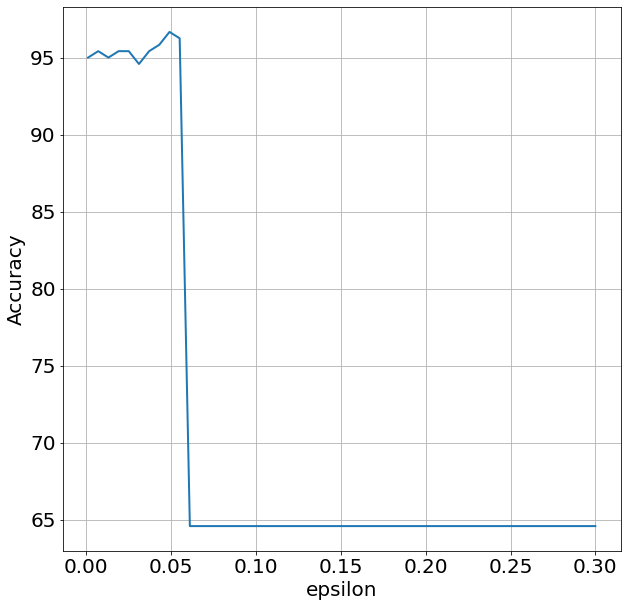

In [13]:
data = pd.read_csv("C:/Users/DEll/Desktop/chaosnet/ChaosNet-master/Datas/hy.csv")
data_name = "hy.csv"
data = np.array(data)
y = np.array(data[:,-1])
X = np.array(data[:,0:-1])
y = y.reshape(len(y),1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
a, b, c, q, length, num_classes, epsilon, FOLD_NO = parameter_file(data_name)

k_cross_validation(FOLD_NO, X_train, y_train, X_test, y_test, num_classes, q, b, epsilon)
